In [1]:
# For suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')


# Importing required modules
import re
from string import punctuation
import numpy as np
import pandas as pd


# For NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


# For ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# Reading data from the file: "tweets_dataset.csv"
df = pd.read_csv('Data/tweets_dataset.csv', names = ['id', 'game/company', 'label', 'tweet'])
df.head()

,id,game/company,label,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
# Describing the data
df.describe(include='object').T

,count,unique,top,freq
game/company,75682,32,TomClancysRainbowSix,2435
label,75682,4,Negative,22808
tweet,74996,69972,It is not the first time that the EU Commissio...,172


In [4]:
# Checking the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            75682 non-null  int64 
 1   game/company  75682 non-null  object
 2   label         75682 non-null  object
 3   tweet         74996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [5]:
# Checking if we have any null values 
df.isnull().sum()

id                0
game/company      0
label             0
tweet           686
dtype: int64

In [6]:
# Checking the rows with null tweet values
df[df['tweet'].isnull()]

,id,game/company,label,tweet
61,2411,Borderlands,Neutral,NaN
553,2496,Borderlands,Neutral,NaN
589,2503,Borderlands,Neutral,NaN
745,2532,Borderlands,Positive,NaN
1105,2595,Borderlands,Positive,NaN
...,...,...,...,...
73972,9073,Nvidia,Positive,NaN
73973,9073,Nvidia,Positive,NaN
74421,9154,Nvidia,Positive,NaN
74422,9154,Nvidia,Positive,NaN


In [7]:
# Dropping the rows with null tweets
df = df.dropna()
df.isnull().sum()

id              0
game/company    0
label           0
tweet           0
dtype: int64

---

## **Data Preprocessing**

In [8]:
# Creating a function for lowercasing the tweets
def convert_to_lowercase(tweets):
    """
    Function for converting the text in the input series to lowercase.

    Parameter:
        - tweets: A Pandas Series containing text data.

    Returns:
        - A Pandas Series with all text in lowercase.
    """

    return tweets.str.lower()


In [9]:
# Testing convert_to_lowercase function
convert_to_lowercase(df['tweet'][:10])

0    im getting on borderlands and i will murder yo...
1    i am coming to the borders and i will kill you...
2    im getting on borderlands and i will kill you ...
3    im coming on borderlands and i will murder you...
4    im getting on borderlands 2 and i will murder ...
5    im getting into borderlands and i can murder y...
6    so i spent a few hours making something for fu...
7    so i spent a couple of hours doing something f...
8    so i spent a few hours doing something for fun...
9    so i spent a few hours making something for fu...
Name: tweet, dtype: object

In [10]:
# Checking if we have any HTML/XML tags in tweets
df[df['tweet'].str.contains('<.*?>')]

,id,game/company,label,tweet
41,2407,Borderlands,Negative,<unk> Gearbox really time to fix this 10 drops...
47,2408,Borderlands,Neutral,Check<unk> this epic streamer!.
57,2410,Borderlands,Negative,why does like<unk> man in borderlands have sli...
87,2415,Borderlands,Positive,FUCK YESSSSSSSS<unk>
131,2422,Borderlands,Irrelevant,do these new @GhostLifestyle<unk> They want dr...
...,...,...,...,...
74583,9184,Nvidia,Neutral,Think im gon screw around with this Nvidia bro...
74603,9187,Nvidia,Positive,<unk> By YouTube: Tips to Put Nvidia Camera on...
74631,9192,Nvidia,Neutral,Save $500 buying the AERO 15 OLED - Award winn...
74655,9196,Nvidia,Negative,Cheap will mean better<unk>!.. techsall.com/go...


In [11]:
# Creating a function for removing HTML/XML tags from the tweets
def remove_html_tags(tweets):
    """
    Function for removing HTML/XML tags from the input series.

    Parameter:
        - tweets: A Pandas Series containing text with HTML/XML tags.

    Returns:
        - A Pandas Series with HTML/XML tags removed.
    """

    return tweets.str.replace("<.*?>", "", regex=True)


In [12]:
# Testing remove_html_tags function
remove_html_tags(df[df['tweet'].str.contains('<.*?>', regex = True)]['tweet'][:10])

41      Gearbox really time to fix this 10 drops in t...
47                            Check this epic streamer!.
57     why does like man in borderlands have slicked ...
87                                       FUCK YESSSSSSSS
131    do these new @GhostLifestyle They want drink G...
221    @Borderlands something seems very broken with ...
245     3 is good so far but Guardian 2 will always b...
261    What a night! I had heeps of fun playing Borde...
317    The April patch + mini DLC for Borderlands 3 i...
323     guys! @Optus appears to have had an accident ...
Name: tweet, dtype: object

### **Expalantion of Regex:**
- **`<`**:
    - This part matches the **literal less-than symbol `<`**.
    - It’s looking for the opening tag in HTML-like text or any string that starts with `<`.

- **`.*?`**:
    - **`.`** matches **any character** (except for a newline).
      - It can match letters, numbers, spaces, symbols, and so on.
    - **`*`** means **zero or more occurrences** of the preceding character (in this case, any character `.`).
      - This means it can match a sequence of any characters, including none.
    - **`?`** makes the `*` **non-greedy** (also called lazy matching).
      - Normally, `*` is **greedy**, meaning it tries to match as much as possible.
      - But with `?`, it tries to match the smallest possible amount of characters, which is useful when dealing with multiple tags.

- **`>`**:
    - This part matches the **literal greater-than symbol `>`**.
    - It’s looking for the closing part of the tag, like `>` at the end of an HTML tag.


In [13]:
# Checking if we have any URLs in the tweets or not
df[df['tweet'].str.contains(r'https?://\S+|www\.\S+', regex = True)]['tweet'].iloc[0]

'Modern Warfare For $38, Borderlands 3 For $20, And More Great Game Deals (PS4, Xbox One, Switch) unsorted.co/modern-warfare… https://t.co/2n68qoJKhU'

In [14]:
# Creating a function for removing urls from the tweets
def remove_urls(tweets):
    """
    Function for removing URLs from the input series.

    Parameter:
        - tweets: A Pandas Series containing text with URLs.

    Returns:
        - A Pandas Series with URLs removed.
    """

    return tweets.str.replace(r"https?://\S+|www\.\S+", "", regex=True)


In [15]:
# Testing remove_urls function
remove_urls(df[df['tweet'].str.contains(r'https?://\S+|www\.\S+', regex = True)]['tweet'][:10]).iloc[0]

'Modern Warfare For $38, Borderlands 3 For $20, And More Great Game Deals (PS4, Xbox One, Switch) unsorted.co/modern-warfare… '

### **Explanation of Regex:**

- **`https?`**:
    - This part matches **'http'** or **'https'**.
    - The `s?` means that the `s` is optional, so it can match both:
      - `http`
      - `https`

- **`://`**:
    - This part matches the literal characters `://` that come after `http` or `https` in a URL.
    - Example: In `https://example.com`, it matches `://`.

- **`\S+`**:
    - **`\S`** matches any **non-whitespace character** (i.e., any character except space, tab, or newline).
    - The `+` means **one or more** of these non-whitespace characters.
    - So, this part matches the rest of the URL after `http://` or `https://`, such as `example.com`.
    - Example: In `https://example.com`, it matches `example.com`.

- **`|` (OR operator)**:
    - The `|` means **"OR"** in regex. It allows us to match **either** the pattern on the left or the pattern on the right.
    - So, this regex will match URLs starting with `http://` or `https://`, **or** URLs starting with `www.`.

- **`www\.`**:
    - This part matches the literal string **"www."**.
    - The backslash (`\`) before the dot (`.`) is important because a dot in regex matches any character. So, we use `\.` to make sure it matches an actual dot (`.`) in "www.".
    - Example: In `www.example.com`, it matches `www.`.

- **`\S+`**:
    - Just like earlier, this part matches **one or more non-whitespace characters**.
    - After `www.`, it matches the rest of the URL, like `example.com`.
    - Example: In `www.example.com`, it matches `example.com`.


In [16]:
# Creating a function for removing punctuations from the tweets
def remove_punctuations(tweets):
    """
    Function for removing punctuation from the input series.

    Parameter:
        - tweets: A Pandas Series containing text with punctuation.

    Returns:
        - A Pandas Series with punctuation removed.
    """

    return tweets.str.translate(str.maketrans("", "", punctuation))


### **Explanation of the `remove_punctuation` Function:**

The `remove_punctuation` function takes a sentence or text and removes all punctuation marks from it, like commas, periods, exclamation marks, etc.

**Key Steps:**

- **`string.punctuation`**:
    - This is a string in Python that contains all punctuation marks (e.g., `!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~`).
- **`str.maketrans('', '', string.punctuation)`**: 
   - This creates a translation table that tells Python to remove any punctuation marks from `string.punctuation`.
   - The empty strings `''` mean "no replacement", so it just removes them.

- **`str.translate()`**: 
   - This method takes the text and applies the translation table to remove all punctuation marks from it.

---

**Example**
```python
txt = "Good night Sam!"
x = "mSa"
y = "eJo"
z = "odnght"
mytable = str.maketrans(x, y, z)
print(txt.translate(mytable))     # G i Joe!
```

In [17]:
# Dictionary of common chat abbreviations and their full forms.
# This dictionary contains popular shorthand used in text messaging and online chatting.
# Each key is a chat abbreviation, and the corresponding value is the full phrase or meaning.
# Reference: https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt

chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing",
    "L8": "Late",
    "SMH": "Shaking My Head",
    "YOLO": "You Only Live Once",
    "TLDR": "Too Long; Didn't Read",
    "FOMO": "Fear Of Missing Out",
    "IDK": "I Don't Know",
    "BFFL": "Best Friends For Life",
    "TMI": "Too Much Information",
    "DM": "Direct Message",
    "STFU": "Shut The F... Up",
    "WTH": "What The Heck",
    "LMAOROTF": "Laughing My A... Off Rolling On The Floor",
    "PPL": "People",
    "SFLR": "Sorry For Late Reply",
    "G2G": "Got To Go",
    "S2R": "Send To Receive"
}


In [18]:
# Creating a function for replacing chat abbreviations with their full meanings
def apply_chat_word_map(tweets):
    """
    Function for replacing abbreviations in the text with their full meanings using a chat word dictionary.

    Parameters:
        - tweets: A pandas Series containing tweets with abbreviations.

    Returns:
        - A pandas Series with abbreviations replaced by their full meanings. 
    """
    return tweets.apply(lambda text: " ".join([chat_words.get(word.upper(), word) for word in text.split()]))


In [19]:
# Testing the apply_chat_word_map function
print(apply_chat_word_map(pd.Series(['IMHO he is the best']))[0])
print(apply_chat_word_map(pd.Series(['FYI Delhi is the capital of India']))[0])

In My Honest/Humble Opinion he is the best
For Your Information Delhi is the capital of India


In [20]:
# Creating a function for removing stop words from the tweets
def remove_stopwords(tweets):
    """
    Function for removing common stopwords from the tweets.

    Parameters:
        - tweets: A pandas Series containing tweets with potential stopwords.

    Returns:
        - A pandas Series with stopwords removed from each tweet. 
    """
    stop_words = set(stopwords.words("english"))
    return tweets.apply(lambda text: " ".join([word for word in text.split() if word not in stop_words]))


In [21]:
# Testing remove_stopwords function
print(remove_stopwords(pd.Series(['I am coming to the borders and I will kill you...']))[0])
print(remove_stopwords(pd.Series(['im coming on borderlands and i will murder you...']))[0])
print(remove_stopwords(pd.Series(['So I spent a few hours making something for fu...']))[0])
print(remove_stopwords(pd.Series(['So I spent a couple of hours doing something f...']))[0])

I coming borders I kill you...
im coming borderlands murder you...
So I spent hours making something fu...
So I spent couple hours something f...


In [22]:
# Regex to finding emojis
emoji_pattern = (
        "[\U0001F600-\U0001F64F" # Emoticons
        "\U0001F300-\U0001F5FF"  # Miscellaneous Symbols and Pictographs
        "\U0001F680-\U0001F6FF"  # Transport and Map Symbols
        "\U0001F700-\U0001F77F"  # Alchemical Symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"  # Enclosed characters
        "]+")

# Checking if we have emojis in our dataset
df[df['tweet'].str.contains(emoji_pattern, regex = True)]['tweet']

576      Top 4 favourite games you say? 🤔. . Sea of Thi...
579      Top 4 favourite games you say? 🤔.. Sea of Thie...
648      Morning~!!. I'm split on playing PSO2 or Borde...
651      Morning~!!. I'm split on playing PSO2 or Borde...
652      1 Morning~!!. I'm split on playing PSO2 or Bor...
                               ...                        
75652    Old lady threatened me and said she was going ...
75658    this quarantine got me bored af playing call o...
75661    @Rainbow6Game when will you ban mnk/cronos pla...
75670    ♥️ Suikoden 2\n1️⃣ Alex Kidd in Miracle World\...
75677    ⭐️ Toronto is the arts and culture capital of ...
Name: tweet, Length: 1029, dtype: object

In [23]:
# Creating a function for removing emojis from the tweets
def remove_emojis(tweets):
    """
    Function to remove emojis from tweets.

    Parameters:
        - tweets: A pandas Series containing tweets with possible emojis.

    Returns:
        - A pandas Series with emojis removed from each tweet.
    """
    return tweets.str.replace(emoji_pattern, "", regex=True)


In [24]:
# Testing remove_emojis function
remove_emojis(df[df['tweet'].str.contains(emoji_pattern, regex = True)]['tweet'][:10])

576    Top 4 favourite games you say? . . Sea of Thie...
579    Top 4 favourite games you say? .. Sea of Thiev...
648    Morning~!!. I'm split on playing PSO2 or Borde...
651    Morning~!!. I'm split on playing PSO2 or Borde...
652    1 Morning~!!. I'm split on playing PSO2 or Bor...
672          My h0rny friend is also a fantastic artist 
708    If Borderlands and Fallout had a child, it wou...
711    If Borderlands and Fallout had a child, it sho...
894                              bURn aLL tHe BAbiES .  
897                                  It aLL tHe BAbiES .
Name: tweet, dtype: object

In [25]:
# Creating a function for removing extra whitespaces from the tweets
def remove_extra_whitespaces(tweets):
    """
    Function for removing extra whitespaces from the tweets.

    Parameters:
        - tweets: A pandas Series containing tweets with extra whitespaces.

    Returns:
        - A pandas Series with extra whitespaces removed.
    """
    
    # Replacing multiple whitespaces with a single space
    tweets = tweets.str.replace(r"\s+", " ", regex=True)
    
    # Trimming leading and trailing whitespaces
    tweets = tweets.str.strip()
    
    return tweets


In [26]:
# Creating a function for lemmatization tweets
def lemmatize_text(tweets):
    """
    Function for lemmatizing each word of the tweets.

    Parameters:
        - tweets: A pandas Series containing tweets.

    Returns:
        - A pandas Series with lemmatized tweets.
    """
    lemmatizer = WordNetLemmatizer()
    return tweets.apply(lambda text: " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(text)]))


In [27]:
# Creatting a pipeline to process the tweets data
tweet_processing_pipeline = Pipeline([
    ('convert_to_lowercase', FunctionTransformer(convert_to_lowercase)),
    ('remove_html_tags', FunctionTransformer(remove_html_tags)),
    ('remove_urls', FunctionTransformer(remove_urls)),
    ('remove_emojis', FunctionTransformer(remove_emojis)),
    ('chat_word_map', FunctionTransformer(apply_chat_word_map)),
    ('remove_punctuations', FunctionTransformer(remove_punctuations)),
    ('remove_stopwords', FunctionTransformer(remove_stopwords)),
    ('remove_extra_space', FunctionTransformer(remove_extra_whitespaces)),
    ('lemmatize', FunctionTransformer(lemmatize_text)),
    ('TF-IDF', TfidfVectorizer())
])

In [28]:
# Splitting the data into X and y
X = df['tweet']
y = df['label']

In [29]:
# Encoding the target variable
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [30]:
# Reshaping y into (n, 1) array for machine learning models
y = y.reshape(-1, 1)
y

array([[3],
       [3],
       [3],
       ...,
       [3],
       [3],
       [2]])

In [31]:
# Checking which class is assigned to which encoded label
dict(zip(encoder.classes_, range(len(encoder.classes_))))

{'Irrelevant': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3}

In [32]:
# Transforming the tweets
X = tweet_processing_pipeline.fit_transform(X)

In [33]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((52497, 37037), (52497, 1)), ((22499, 37037), (22499, 1)))

---

### **Logistic Regression**

In [34]:
# Creating an instance of LogisticRegression and training it
model = LogisticRegression(C = 10, solver='saga', max_iter=10000, random_state=101)
model.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=10000, random_state=101, solver='saga')

In [35]:
# Making predictions
y_pred = model.predict(X_test)

In [36]:
# Evaluating the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted')}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted')}")
print(f"F1-Score: {f1_score(y_test, y_pred, average='weighted')}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, model.predict_proba(X_test), average='weighted', multi_class='ovr')}")

Accuracy: 0.839770656473621
Precision: 0.8409766039520011
Recall: 0.839770656473621
F1-Score: 0.8398620123856603
ROC-AUC Score: 0.9624658875784563


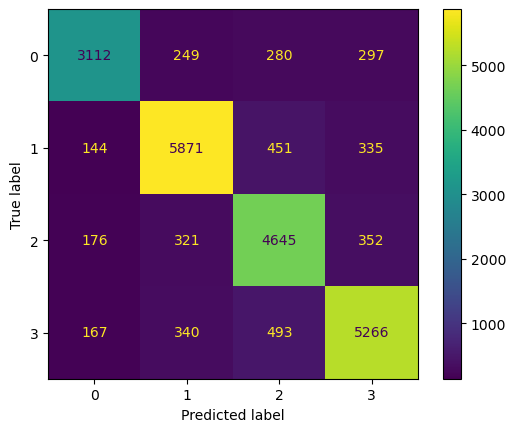

In [37]:
# Checking the Confusion Matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

---

### **SGDClassifier**

In [38]:
# Creating an instance of SGDClassifier and training it
model = SGDClassifier(loss = "modified_huber", penalty='elasticnet', l1_ratio = 0.05, learning_rate='adaptive', 
                      eta0=0.1, early_stopping=True, max_iter=10000, random_state=101)
model.fit(X_train, y_train)

SGDClassifier(early_stopping=True, eta0=0.1, l1_ratio=0.05,
              learning_rate='adaptive', loss='modified_huber', max_iter=10000,
              penalty='elasticnet', random_state=101)

In [39]:
# Making predictions
y_pred = model.predict(X_test)

In [40]:
# Evaluating the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted')}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted')}")
print(f"F1-Score: {f1_score(y_test, y_pred, average='weighted')}")

Accuracy: 0.7772789901773413
Precision: 0.779664119782339
Recall: 0.7772789901773413
F1-Score: 0.776293988358727


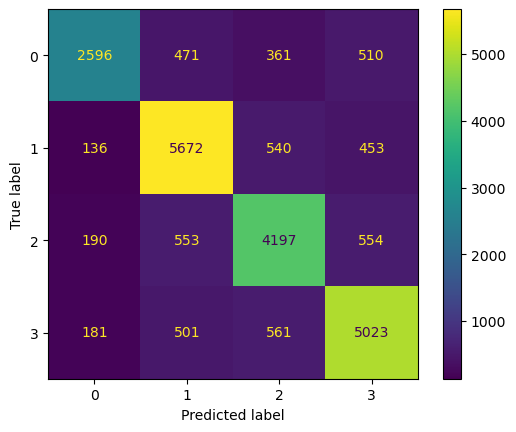

In [41]:
# Checking the Confusion Matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

---

### **RandomForestClassifier**

In [42]:
# Creating an instance of RandomForestClassifier and training it
model = RandomForestClassifier(n_estimators=75, oob_score=True, random_state=101)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=75, oob_score=True, random_state=101)

In [43]:
# Making predictions
y_pred = model.predict(X_test)

In [44]:
# Evaluating the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted')}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted')}")
print(f"F1-Score: {f1_score(y_test, y_pred, average='weighted')}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, model.predict_proba(X_test), average='weighted', multi_class='ovr')}")

Accuracy: 0.9035068225254456
Precision: 0.9063033104615562
Recall: 0.9035068225254456
F1-Score: 0.9036110602345598
ROC-AUC Score: 0.9832777831099044


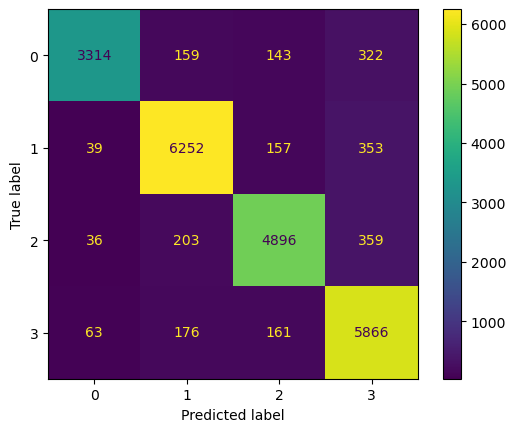

In [45]:
# Checking the Confusion Matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

---

### **MultinomialNB**

In [46]:
# Creating an instance of MultinomialNB and training it
model = MultinomialNB(alpha=0.001)
model.fit(X_train, y_train)

MultinomialNB(alpha=0.001)

In [47]:
# Making predictions
y_pred = model.predict(X_test)

In [48]:
# Evaluating the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted')}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted')}")
print(f"F1-Score: {f1_score(y_test, y_pred, average='weighted')}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, model.predict_proba(X_test), average='weighted', multi_class='ovr')}")

Accuracy: 0.8155029112404996
Precision: 0.8223643947934822
Recall: 0.8155029112404996
F1-Score: 0.8151516327407836
ROC-AUC Score: 0.9573681330486783


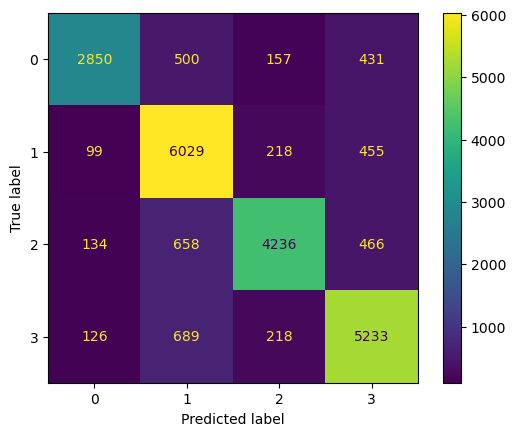

In [49]:
# Checking the Confusion Matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

---

### **Final Thoughts**

After evaluating the performance of different models, the **RandomForestClassifier (RFC)** emerges as the top choice for this task. Here's why:

- **RFC** outperforms all other models with the highest **Accuracy (0.90)**, **Precision (0.91)**, **Recall (0.90)**, **F1-Score (0.90)**, and the best **ROC-AUC Score (0.98)**. This indicates that the model is highly effective in both classifying correctly and distinguishing between the classes.

- **Logistic Regression** is also a solid performer with **Accuracy (0.84)** and a good **ROC-AUC Score (0.96)**. However, it trails behind **RFC** in terms of precision, recall, and F1-Score, meaning it’s slightly less effective at balancing false positives and false negatives.

- **SGDClassifier** shows lower performance across all metrics, making it a less favorable choice for this task. It may not be capturing the underlying patterns in the data as effectively as the other models.

- **MultinomialNB** provides decent results, especially in terms of **Precision (0.82)**, but it still falls behind **RFC** in terms of accuracy and overall performance.
